In [138]:
import pandas as pd
import os
import zipfile
import StringIO
import requests
import statsmodels.api as sm
from IPython.display import clear_output

import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('white')
%matplotlib inline

# Death data

In [2]:
BASE_URL = "https://www.nber.org/mortality/{0}/mort{0}.csv.zip"
DOWNLOAD_DEST_BASE = 'nchs_mcd_rawdata'
START_YEAR = 2000
END_YEAR = 2017

In [3]:
# If raw data folder doesn't exist, create it
if not os.path.exists(DOWNLOAD_DEST_BASE):
    print 'Making "{0}" directory...'.format(DOWNLOAD_DEST_BASE)
    os.makedirs('{0}'.format(DOWNLOAD_DEST_BASE))

In [4]:
def download_raw_data_by_year(year, base_url=BASE_URL, download_dest_base=DOWNLOAD_DEST_BASE):
    """
    See documentation stuff here:
    https://www.nber.org/data/vital-statistics-mortality-data-multiple-cause-of-death.html
    """
    year = str(year)
    
    # Check if already exists
    if os.path.exists(os.path.join(download_dest_base, '{0}.csv'.format(year))):
        print "Already have data for {0}".format(year)
        return
    
    # Specify file locations
    url = base_url.format(year)
    download_dest = os.path.join(download_dest_base, year)

    # Download data
    r = requests.get(url, stream=True)
    with zipfile.ZipFile(StringIO.StringIO(r.content)) as zf:
        zf.extractall(download_dest)

    # Move CSV to main directory and delete empty folder
    current_filename = os.path.join(download_dest, 'mort{0}.csv'.format(year))
    new_filename = os.path.join(download_dest_base, '{0}.csv'.format(year))
    os.rename(current_filename, new_filename)
    os.rmdir(os.path.join(download_dest_base, year))
    
    print "Downloaded data for {0}".format(year)

In [5]:
def download_raw_data(start_year=START_YEAR, end_year=END_YEAR, 
                      base_url=BASE_URL, download_dest_base=DOWNLOAD_DEST_BASE):
    years = range(start_year, end_year+1)
    
    for year in years:
        download_raw_data_by_year(year, base_url, download_dest_base)

In [6]:
download_raw_data()

Already have data for 2000
Already have data for 2001
Already have data for 2002
Already have data for 2003
Already have data for 2004
Already have data for 2005
Already have data for 2006
Already have data for 2007
Already have data for 2008
Already have data for 2009
Already have data for 2010
Already have data for 2011
Already have data for 2012
Already have data for 2013
Already have data for 2014
Already have data for 2015
Already have data for 2016
Already have data for 2017


# Population data

In [7]:
OTHER_DATA_DEST_BASE = 'other_data'

### 2010-2018

In [8]:
# Source url: https://www.census.gov/data/tables/time-series/demo/popest/2010s-national-detail.html
# Description: https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2018/nc-est2018-agesex-res.pdf
POP_DATA_URL_2010 = 'https://www2.census.gov/programs-surveys/popest/technical-documentation/file-layouts/2010-2018/nc-est2018-agesex-res.csv'

In [9]:
# If raw data folder doesn't exist, create it
if not os.path.exists(OTHER_DATA_DEST_BASE):
    print 'Making "{0}" directory...'.format(DOWNLOAD_DEST_BASE)
    os.makedirs('{0}'.format(OTHER_DATA_DEST_BASE))

In [10]:
def download_2010_pop_data(pop_data_url_2010=POP_DATA_URL_2010):
    """
    Download population data from 2010-2018
    """
    # Download
    pop_data_2010_raw = pd.read_csv(pop_data_url_2010, index_col=None, header=0)
    
    # Clean
    col_map = {
        c: c[-4:]
        for c in pop_data_2010_raw.columns if 'POPESTIMATE' in c
    }
    col_map['AGE'] = 'age'
    col_map['SEX'] = 'sex'
    gender_map = {
        0: 'total',
        1: 'male',
        2: 'female',
    }

    pop_data_2010 = pop_data_2010_raw[col_map].rename(columns=col_map)
    pop_data_2010['sex'] = pop_data_2010['sex'].replace(gender_map)
    pop_data_2010['age'] = pop_data_2010['age'].replace(999, 'total')

    pop_data_2010 = (
        pop_data_2010
        .set_index(['sex', 'age'])
        .T
        .sort_index()
    )
    
    # Return
    return pop_data_2010['total'], pop_data_2010['male'], pop_data_2010['female']

In [11]:
def load_pop_data_2010(pop_data_url_2010=POP_DATA_URL_2010, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_2010_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_2010_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_2010_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_2010_total = pd.read_csv(total_filename, index_col=0)
        pop_data_2010_total.columns = [int(x) for x in pop_data_2010_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 2010-2018 population data"
        pop_data_2010_total, males, females = download_2010_pop_data(pop_data_url_2010)
        
        pop_data_2010_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_2010_total

In [33]:
pop_data_2010 = load_pop_data_2010()

Loading other_data\pop_data_2010_total.csv


In [ ]:
(pop_data_2010[26]*100./pop_data_2010['total']).plot()

### 2000-2009

In [12]:
# Source url: https://www.census.gov/data/datasets/time-series/demo/popest/intercensal-2000-2010-national.html
POP_DATA_URL_2000 = 'https://www2.census.gov/programs-surveys/popest/datasets/2000-2010/intercensal/national/us-est00int-alldata.csv'

In [13]:
def download_2000_pop_data(pop_data_url_2000=POP_DATA_URL_2000, month=7):
    """
    Download population data from 2000-2009
    Estimates are available for April and July (??), I use July.
    """   
    # Download
    pop_data_2000_raw = pd.read_csv(pop_data_url_2000, index_col=None, header=0)
    
    # Estimates are available for April and July (??), I use July.
    pop_data_2000 = pop_data_2000_raw[pop_data_2000_raw['MONTH'] == 7]

    # Clean
    def clean_pop_2000(df):
        df = df.rename(columns={999: 'total'})
        df.index.name = None
        df.columns.name = None
        return df

    pop_data_2000_total = pd.pivot_table(pop_data_2000, index='YEAR', columns='AGE', values='TOT_POP')
    pop_data_2000_male = pd.pivot_table(pop_data_2000, index='YEAR', columns='AGE', values='TOT_MALE')
    pop_data_2000_female = pd.pivot_table(pop_data_2000, index='YEAR', columns='AGE', values='TOT_FEMALE')

    pop_data_2000_total = clean_pop_2000(pop_data_2000_total)
    pop_data_2000_male = clean_pop_2000(pop_data_2000_male)
    pop_data_2000_female = clean_pop_2000(pop_data_2000_female)
    
    # Return
    return pop_data_2000_total, pop_data_2000_male, pop_data_2000_female

In [14]:
def load_pop_data_2000(pop_data_url_2000=POP_DATA_URL_2000, other_data_dest_base=OTHER_DATA_DEST_BASE):
    total_filename = os.path.join(other_data_dest_base, 'pop_data_2000_total.csv')
    male_filename = os.path.join(other_data_dest_base, 'pop_data_2000_male.csv')
    female_filename = os.path.join(other_data_dest_base, 'pop_data_2000_female.csv')
    
    if os.path.exists(total_filename):
        print "Loading", total_filename
        pop_data_2000_total = pd.read_csv(total_filename, index_col=0)
        pop_data_2000_total.columns = [int(x) for x in pop_data_2000_total.columns if x != 'total'] + ['total']
    else:
        print "Downloading 2010-2018 population data"
        pop_data_2000_total, males, females = download_2000_pop_data(pop_data_url_2000)
        
        pop_data_2000_total.to_csv(total_filename)
        males.to_csv(male_filename)
        females.to_csv(female_filename)
        
        print "Saved", total_filename
        
    return pop_data_2000_total

In [34]:
pop_data_2000 = load_pop_data_2000()

Loading other_data\pop_data_2000_total.csv


### 1990-2000

In [347]:
#https://www.census.gov/data/datasets/time-series/demo/popest/intercensal-1990-2000-national.html

### 1980-1990

In [348]:
#https://www.census.gov/data/datasets/time-series/demo/popest/1980s-national.html

### <1980

In [349]:
#https://www.census.gov/data/tables/time-series/demo/popest/pre-1980-national.html

### Combine

In [39]:
# Note that the "max bucket" varies over time, but doesn't matter for our purposes
# See https://www.census.gov/dataviz/visualizations/055/

In [46]:
dict_of_pop_data = {
    '2010-2017': pop_data_2010,
    '2000-2009': pop_data_2000.loc[2000:2009],
    #'1990-1999': None,
    #'1980-1989': None,
    #'<1980': None,
}

In [53]:
pop_data = pd.concat(dict_of_pop_data.values(), axis=0)
pop_data = pop_data.fillna(0)
pop_data = pop_data.sort_index()

clear_output() # stupid warning

# Get just suicide data

In [15]:
DEATH_VAR = 'ucr39'
SUICIDE_VAL = 40
CLEAN_DATA_BASE = 'cleaned_data'

In [16]:
if not os.path.exists(CLEAN_DATA_BASE):
    os.makedirs(CLEAN_DATA_BASE)
    print "Created", CLEAN_DATA_BASE

In [19]:
def get_suicide_data_by_year(death_var=DEATH_VAR, suicide_val=SUICIDE_VAL,
                             start_year=START_YEAR, end_year=END_YEAR,
                             raw_data_loc_base=DOWNLOAD_DEST_BASE, suicide_data_loc_base=CLEAN_DATA_BASE):
    for year in range(start_year, end_year+1):
        # Check if already exists
        new_filename = os.path.join(suicide_data_loc_base, '{0}.csv'.format(year))
        if os.path.exists(new_filename):
            print new_filename, "already exists"
            continue
        
        # Load data
        print "Loading", year
        filename = os.path.join(raw_data_loc_base, '{0}.csv'.format(year))
        data = pd.read_csv(filename)
        
        # Filter to just suicides
        suicide_data = data[data[death_var] == suicide_val]
        
        # Clean data
        # Drop bad data
        # TODO: what is going on here
        if year >= 2010:
            prefix = suicide_data['age'].apply(lambda x: int(str(x)[:2]))
            clean_suicide_data = suicide_data[prefix == 10].copy()
            actual_age = clean_suicide_data['age'].apply(lambda x: int(str(x)[2:]))
            clean_suicide_data['actual_age'] = actual_age
        else:
            clean_suicide_data = suicide_data[suicide_data['age'] != 999].copy()
            clean_suicide_data['actual_age'] = clean_suicide_data['age']        

        # Drop irrelevant vars
        final_suicide_data = clean_suicide_data[['sex', 'actual_age', 'monthdth']].copy()
        final_suicide_data = final_suicide_data.rename(columns={'actual_age': 'age', 'monthdth': 'month'})
        final_suicide_data['year'] = year
        #final_suicide_data['age_group'] = final_suicide_data['age'].map(AGE_GROUPS_MAP)
        
        # Save data
        final_suicide_data.to_csv(new_filename)
        print "Saved", new_filename

In [20]:
get_suicide_data_by_year()

cleaned_data\2000.csv already exists
Loading 2001


C:\Users\basil\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2824: DtypeWarning: Columns (8,9,10,11,15,17,18,86,89,92,95,98,101,104,107,110,113,125,126,127,128,129,130,131,132,133,134,135) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Saved cleaned_data\2001.csv
Loading 2002


C:\Users\basil\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2824: DtypeWarning: Columns (8,9,10,11,15,17,18,86,89,92,95,98,101,104,107,110,126,127,128,129,130,131,132,133,134) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Saved cleaned_data\2002.csv
Loading 2003


C:\Users\basil\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2824: DtypeWarning: Columns (10,11,14,15,75,78,81,84,87,90,93,96,99,102,116,117,118,119,120,121,122,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Saved cleaned_data\2003.csv
Loading 2004


C:\Users\basil\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2824: DtypeWarning: Columns (10,11,14,15,75,78,81,84,87,90,93,96,99,116,117,118,119,120,121,122,123,124) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Saved cleaned_data\2004.csv
Loading 2005


C:\Users\basil\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2824: DtypeWarning: Columns (60,63,66,69,72,75,78,81,84,98,99,100,101,102,103,104,105) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Saved cleaned_data\2005.csv
Loading 2006


C:\Users\basil\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2824: DtypeWarning: Columns (60,63,66,69,72,75,78,81,84,98,99,100,101,102,103,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Saved cleaned_data\2006.csv
Loading 2007


C:\Users\basil\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2824: DtypeWarning: Columns (60,63,66,69,72,75,78,81,98,99,100,101,102,103,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Saved cleaned_data\2007.csv
Loading 2008


C:\Users\basil\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2824: DtypeWarning: Columns (60,63,66,69,72,75,78,81,98,99,100,101,102,103,104,105) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Saved cleaned_data\2008.csv
Loading 2009


C:\Users\basil\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2824: DtypeWarning: Columns (39,42,45,48,51,54,57,60,63,66,69,72,75,78,81,84,87,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Saved cleaned_data\2009.csv
cleaned_data\2010.csv already exists
cleaned_data\2011.csv already exists
cleaned_data\2012.csv already exists
cleaned_data\2013.csv already exists
cleaned_data\2014.csv already exists
cleaned_data\2015.csv already exists
cleaned_data\2016.csv already exists
cleaned_data\2017.csv already exists


# Computing suicide rates

### Computing

In [21]:
def stack_suicide_data(start_year=START_YEAR, end_year=END_YEAR, suicide_data_loc_base=CLEAN_DATA_BASE):
    data = {}
    for year in range(start_year, end_year+1):
        filename = os.path.join(suicide_data_loc_base, '{0}.csv'.format(year))
        data[year] = pd.read_csv(filename, index_col=0)
        
    stacked_data = pd.concat(data.values(), axis=0)
    return stacked_data

In [23]:
suicide_data = stack_suicide_data()

In [124]:
AGE_GROUPS = {
    '<15': range(0, 15),
    '15-18': range(15, 19),
    '19-25': range(19, 26),
    '>25': range(26, 100)
}

#AGE_GROUPS = {
#    '<18': range(0, 18),
#    '>=18': range(18, 100),
#}

def get_age_order(age_groups):
    first_val = [k for k in age_groups if '<' in k]
    last_val = [k for k in age_groups if '>' in k]
    other = [k for k in age_groups if k not in first_val and k not in last_val]
    other = sorted(other)
    return first_val + other + last_val
GROUP_ORDER = ['<15', '15-18', '19-25', '>25']
GROUP_ORDER = get_age_order(AGE_GROUPS)

def get_age_groups_map(age_groups):
    return {
        v: k
        for k in age_groups
        for v in age_groups[k]
    }
AGE_GROUPS_MAP = get_age_groups_map(AGE_GROUPS)

In [125]:
suicide_data['age_group'] = suicide_data['age'].map(AGE_GROUPS_MAP)

In [126]:
arbitrary_column = 'sex' # just to avoid having the same thing repeated over and over
suicide_counts_by_age_group_by_monthyear = (
    suicide_data
    .groupby(['year', 'month', 'age_group'])
    .count()
    [arbitrary_column]
    .unstack()
)

In [127]:
pop_by_group = pd.DataFrame()
for group_k, group_v in AGE_GROUPS.iteritems():
    pop_by_group[group_k] = pop_data[group_v].sum(1)
pop_by_group = pop_by_group[GROUP_ORDER]
pop_by_group.index.name = 'year'

In [128]:
blank_df = pd.DataFrame(index=suicide_counts_by_age_group_by_monthyear.index)
pop_by_group_by_monthyear = blank_df.join(pop_by_group)

In [129]:
suicide_rate_by_monthyear = suicide_counts_by_age_group_by_monthyear/pop_by_group_by_monthyear

suicide_rate_per100k_annualized_by_monthyear = suicide_rate_by_monthyear*12*100000

In [130]:
tmp = suicide_rate_per100k_annualized_by_monthyear.reset_index()
del tmp['year']
suicide_rate_per100k_annualized_by_month = tmp.groupby('month').mean()

### Plotting

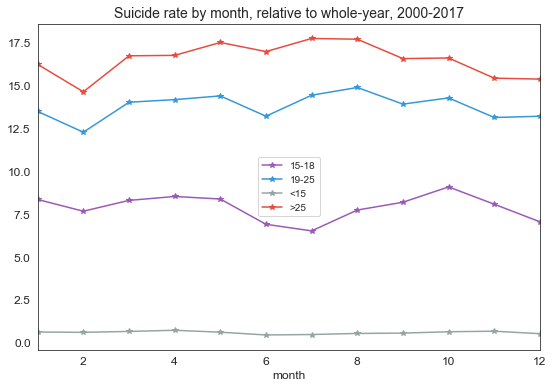

In [131]:
COLORS = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

suicide_rate_per100k_annualized_by_month.plot(figsize=(9, 6), style='-*', color=COLORS)
_ = plt.title('Suicide rate by month, relative to whole-year' + year_range_str, fontsize=14)
_ = plt.xticks(fontsize=12)
_ = plt.xlabel('month', fontsize=12)
_ = plt.yticks(fontsize=12)
#_ = plt.axhline(1.0, color='gray')

In [132]:
months_map = {
    1: 'Jan.',
    2: 'Feb.',
    3: 'Mar.',
    4: 'Apr.',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'Aug.',
    9: 'Sep.',
    10: 'Oct.',
    11: 'Nov.',
    12: 'Dec.',
}

rel = (suicide_rate_per100k_annualized_by_month
 /suicide_rate_per100k_annualized_by_month.mean()
# /suicide_rate_per100k_annualized_by_month.loc[9]
)
rel = rel.rename(index=months_map)

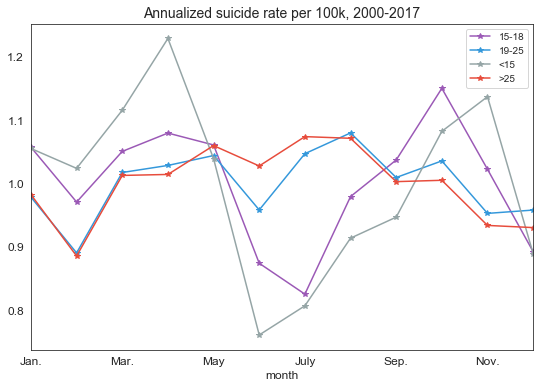

In [133]:
COLORS = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]

rel.plot(figsize=(9, 6), style='-*', color=COLORS)
_ = plt.title('Annualized suicide rate per 100k' + year_range_str, fontsize=14)
_ = plt.xticks(fontsize=12)
_ = plt.xlabel('month', fontsize=12)
_ = plt.yticks(fontsize=12)
#_ = plt.axhline(1.0, color='gray')

In [134]:
suicide_rate_per100k_annualized_by_month

,15-18,19-25,<15,>25
month,,,,
1,8.354390,13.494667,0.618279,16.241302
2,7.670255,12.281440,0.599908,14.639978
3,8.301958,14.031444,0.653651,16.741817
4,8.530461,14.184952,0.720015,16.767500
5,8.382228,14.400606,0.608891,17.520171
6,6.907016,13.216498,0.445859,16.988762
7,6.522186,14.440996,0.472815,17.754160
8,7.738492,14.892690,0.535373,17.710559
9,8.194755,13.922471,0.554798,16.579858


### Regressing

In [157]:
df = suicide_rate_per100k_annualized_by_monthyear.reset_index()
df['year_month'] = df['year'].astype(str) + '-' + df['month'].astype(str)
del df['year']
del df['month']
df = df.set_index('year_month')
df = df.stack().reset_index()
df = df.rename(columns={
    'level_1': 'age_group',
    0: 'suicide_rate_per100k_annualized'
})
df['year'] = df['year_month'].str[:4]
df['month'] = df['year_month'].str[5:]

In [158]:
df.head()

,year_month,age_group,suicide_rate_per100k_annualized,year,month
0,2000-1,15-18,8.308629,2000,1
1,2000-1,19-25,12.674456,2000,1
2,2000-1,<15,0.716657,2000,1
3,2000-1,>25,14.529730,2000,1
4,2000-2,15-18,7.715155,2000,2


In [160]:
reg = sm.OLS.from_formula(data=df, formula='suicide_rate_per100k_annualized ~ C(month) + C(year) + C(age_group)').fit()